# Die Corona Lage

## Daten URLs

In [1]:
URL_CORONA_INFECTED = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/" + \
                      "csse_covid_19_data/csse_covid_19_time_series/" + \
                      "time_series_covid19_confirmed_global.csv"
URL_CORONA_RECOVER = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/" + \
                      "csse_covid_19_data/csse_covid_19_time_series/" + \
                      "time_series_covid19_recovered_global.csv"
URL_CORONA_DEATHS = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/" + \
                      "csse_covid_19_data/csse_covid_19_time_series/" + \
                      "time_series_covid19_deaths_global.csv"

## Umsetzung

In [13]:
import csv                       # Intial data parsing (or other/custom)
import datetime                  # Date formatting (optional)

import numpy as np               # Masking, statistics, diffs
import matplotlib.pyplot as plt  # All plotting
import requests                  # Get data from github

%matplotlib notebook

### Herunterladen der Daten von Github

In [3]:
with requests.get(URL_CORONA_INFECTED) as data:
    infected = list(csv.reader(data.content.decode('utf-8').splitlines(), delimiter=','))
with requests.get(URL_CORONA_RECOVER) as data:
    recovered = list(csv.reader(data.content.decode('utf-8').splitlines(), delimiter=','))
with requests.get(URL_CORONA_DEATHS) as data:
    deaths = list(csv.reader(data.content.decode('utf-8').splitlines(), delimiter=','))

### Aufreinigen der Daten

* Aus der Infected Tabelle sind die Datumsangaben entnommen
* Daten in eine übersichtliche Dictionary Struktur bringen `data[region][state]["infected"/"recovered"/"deaths"]`.
* Für Länder mit mehreren Provinzen Gesamtzahlen berechnen.
* Für manche Ländern sin für einzelne Provinzen keine *recovered* Zahlen gegeben

In [20]:
data = {}
dates = [datetime.datetime.strptime(date, "%m/%d/%y").date() for date in infected[0][4:]]
for state, region, latitude, longitude, *numbers in infected[1:]:
    numbers = np.array(numbers, dtype=np.int)
    state = state if state != "" else "total"
    if region not in data.keys():
        data[region] = {state: {"lat": latitude, "long": longitude, "infected": numbers}}
    else:
        data[region][state] = {"lat": latitude, "long": longitude, "infected": numbers}
for region, state_data in data.items():
    if len(state_data) > 1:
        state_data["total"] = {"infected": np.sum(np.array([state["infected"]
                                                            for state in state_data.values()]), axis=0)}
for state, region, latitude, longitude, *numbers in recovered[1:]:
    numbers = np.array(numbers, dtype=np.int)
    state = state if state != "" else "total"
    data[region][state]["recovered"] = numbers
for state, region, latitude, longitude, *numbers in deaths[1:]:
    numbers = np.array(numbers, dtype=np.int)
    state = state if state != "" else "total"
    data[region][state]["deaths"] = numbers
for region, state_data in data.items():
    if len(state_data) > 1 and isinstance(state_data["total"].get("recovered", False), bool):
        state_data["total"]["recovered"] = np.sum(np.array([nums["recovered"]
                                                            for state, nums in state_data.items()
                                                            if state != "total"
                                                           ]), axis=0)
    if len(state_data) > 1 and isinstance(state_data["total"].get("deaths", False), bool):
        state_data["total"]["deaths"] = np.sum(np.array([nums["deaths"]
                                                         for state, nums in state_data.items()
                                                         if state != "total"
                                                        ]), axis=0)
"""
for region, state_data in data.items():
    print(region)
    for state, nums in state_data.items():
        print(state)
        print(nums['infected'])
        print(nums.get('recovered', data[region]["total"]["recovered"]))
        print(nums['deaths'])
"""

'\nfor region, state_data in data.items():\n    print(region)\n    for state, nums in state_data.items():\n        print(state)\n        print(nums[\'infected\'])\n        print(nums.get(\'recovered\', data[region]["total"]["recovered"]))\n        print(nums[\'deaths\'])\n'

### Statistische Auswertung

* 1
* 2
* 3

In [5]:
def get_diff_data(country, state, dtype):
    return np.diff(data[country][state][dtype], prepend=[0])

def get_diff_max(country, state, dtype):
    return max(get_diff_data(country, state, dtype))

def get_diff_mean(country, state, dtype, last_x_days=None):
    start_idx = 0 if last_x_days is None else 0 - last_x_days
    return np.mean(get_diff_data(country, state, dtype)[start_idx:])

def above_treshold(country, state, dtype, treshold):
    mask = get_diff_data(country, state, dtype) > treshold
    return np.arange(len(dates))[mask], get_diff_data(country, state, dtype)[mask]

def days_above_treshold(country, state, dtype, treshold, last_x_days=None):
    start_idx = 0 if last_x_days is None else 0 - last_x_days
    return np.sum(get_diff_data(country, state, dtype)[start_idx:] > treshold)

def mean_newly_infected(country, state, last_x_days=None):
    start_idx = 0 if last_x_days is None else 0 - last_x_days
    return np.mean(get_diff_data(country, state, "infected")[start_idx:])

def get_ill_data(country, state):
    return data[country][state]["infected"] - data[country][state]["recovered"]

def maximum_ill(country, state):
    return max(get_ill_data(country, state))

def mean_ill(country, state, last_x_days=None):
    start_idx = 0 if last_x_days is None else 0 - last_x_days
    return np.mean(get_ill_data(country, state)[start_idx:])

def reproduction_number(country, state, time_gen=4, last_x_days=None):
    start_idx = 0 if last_x_days is None else 0 - last_x_days
    diff_data = get_diff_data(country, state, "infected")
    if start_idx < time_gen:
        nom = np.concatenate([np.zeros((time_gen - start_idx)), diff_data])[: -time_gen + start_idx]
        denom = diff_data[start_idx:]
    else:
        nom = diff_data[start_idx - time_gen: -time_gen]
        denom = diff_data[start_idx:]
    return np.divide(denom, nom, where=nom > 0, out=nom)

def print_statistics(country, state, treshold=False):
    stats = f"""{"#" * (23 + (len(country) + len(state)))}
# Information for {country} - {state} #
{"#" * (23 + (len(country) + len(state)))}

Total Infected: {data[country][state]["infected"][-1]:>10} | Total Recovered: {data[country][state]["recovered"][-1]:>10} | Total Deaths: {data[country][state]["deaths"][-1]:>10}
---------------------------+-----------------------------+-------------------------
Infected Today: {get_diff_data(country, state, "infected")[-1]:>10} | Recovered Today: {get_diff_data(country, state, "infected")[-1]:>10} | Deaths Today: {get_diff_data(country, state, "deaths")[-1]:>10}
Infected Mean Total: {get_diff_mean(country, state, "infected", last_x_days=None):>5.0f} | Recovered Mean Total: {get_diff_mean(country, state, "recovered", last_x_days=None):>5.0f} | Deaths Mean Total: {get_diff_mean(country, state, "deaths", last_x_days=None):>5.0f}
Infected Mean Week: {get_diff_mean(country, state, "infected", last_x_days=7):>6.0f} | Recovered Mean Week: {get_diff_mean(country, state, "recovered", last_x_days=7):>6.0f} | Deaths Mean Week: {get_diff_mean(country, state, "deaths", last_x_days=7):>6.0f}
---------------------------+-----------------------------+-------------------------
Currently Ill: {get_ill_data(country, state)[-1]:>11} | Mean Ill Week: {mean_ill(country, state, 7):>12.0f} | Maximum Ill: {maximum_ill(country, state):>11}"""
    if treshold:
        stats += f"\nTreshold: {treshold:>16} | Days Above: {days_above_treshold(country, state, 'infected', treshold):>15} | Days Above Week: {days_above_treshold(country, state, 'infected', treshold, 7):>7}"
    stats += "---------------------------+-----------------------------+-------------------------"
    print(stats)

### Grafische Darstellung

* `plot_data` stellt die Infektions-, Heilungs- und Todeszahlen für ein Land und Provinz dar.
* `plot_current_infected` stellt die aktuell Infizierten in einem Land dar.
* `plot_diff` stellt die aktuelle Änderung der Infektions-, Heilungs- und Todeszahlen in einem Land dar.
* `plot_above_treshold` zeigt jene Tage, an denen die Neuinfektionen über einem bestimmten Wert lagen.

In [67]:
import scipy.ndimage as ndi
import matplotlib.cm as cm
import matplotlib.colors as colors

def plot_data(country, state, log=False, ticks=30):
    plt.figure(f"Data - {country}", [8, 5], 100)
    plt.title(f"Corona in {country} - {state}")
    plt.plot(range(len(dates)), data[country][state]["infected"], 'y', label="Infected")
    plt.plot(range(len(dates)), data[country][state]["recovered"], 'g', label="recovered")
    plt.plot(range(len(dates)), data[country][state]["deaths"], 'r', label="deaths")
    if log:
        plt.semilogy()
    plt.legend()
    plt.ylim(1 if log else 0, max(data[country][state]["infected"]) * (3 if log else 1.05))
    plt.xlim(0, len(dates))
    plt.xticks(ticks=range(len(dates))[::ticks], labels=[date for date in dates[::ticks]])
    plt.show()

def plot_current_infected(country, state, log=False, ticks=30):
    plt.figure(f"Current Infected - {country}", [8, 5], 100)
    plt.title(f"Corona in {country} - {state}")
    plt.plot(range(len(dates)), get_ill_data(country, state), 'k', label="Currently Infected")
    if log:
        plt.semilogy()
    plt.legend()
    plt.ylim(1 if log else 0, max(get_ill_data(country, state)) * (3 if log else 1.05))
    plt.xlim(0, len(dates))
    plt.xticks(ticks=range(len(dates))[::ticks], labels=[date for date in dates[::ticks]])
    plt.show()
    
def plot_diff(country, state, log=False, ticks=30, sigma=0.1):
    plt.figure(f"Diff Data - {country}", [8, 5], 100)
    plt.title(f"Corona in {country} - {state}")
    plt.plot(range(len(dates)), ndi.gaussian_filter1d(get_diff_data(country, state, "infected"), sigma=sigma), 'y', label="Infected")
    plt.plot(range(len(dates)), ndi.gaussian_filter1d(get_diff_data(country, state, "recovered"), sigma=sigma), 'g', label="recovered")
    plt.plot(range(len(dates)), ndi.gaussian_filter1d(get_diff_data(country, state, "deaths"), sigma=sigma), 'r', label="deaths")
    if log:
        plt.semilogy()
    plt.ylim(1 if log else 0, get_diff_max(country, state, "infected") * (3 if log else 1.05))
    plt.xlim(0, len(dates))
    plt.legend()
    plt.xticks(ticks=range(len(dates))[::ticks], labels=[date for date in dates[::ticks]])
    plt.show()
    
def plot_above_treshold(country, state, treshold, log=False, ticks=30):
    plt.figure(f"Above Treshold-{country}", [8, 5], 100)
    diff_infected = get_diff_data(country, state, "infected")
    treshold_mask = diff_infected > treshold
    x_points = np.array(range(len(dates)))
    plt.title(f"Corona in {country} - {state}")
    plt.vlines(x_points[treshold_mask], ymin=0, ymax=1e10, colors=[1, 0.85, 0.85, 1], linewidths=4.5, label=f"above {treshold}")
    plt.plot(x_points, diff_infected, 'y', label="Infected")
    if log:
        plt.semilogy()
    plt.ylim(1 if log else 0, get_diff_max(country, state, "infected") * (3 if log else 1.05))
    plt.xlim(0, len(dates))
    plt.legend()
    plt.xticks(ticks=range(len(dates))[::ticks], labels=[date for date in dates[::ticks]])
    plt.show()

def plot_reproduction_number(country, state, time_gen=4, ticks=30, sigma=0.1, yrange=None):
    plt.figure(f"Reproduction Number-{country}", [8, 5], 100)
    plt.title(f"Reproduction Number in {country} - {state}")
    r = ndi.gaussian_filter1d(reproduction_number(country, state, last_x_days=None, time_gen=5), sigma=sigma)
    plt.plot(range(len(dates)), r, 'k', label="reproduction number")
    plt.xticks(ticks=range(len(dates))[::ticks], labels=[date for date in dates[::ticks]])
    plt.xlim(0, len(dates))
    plt.hlines([1], xmin=-1, xmax=len(dates)+1)
    if yrange is not None:
        plt.ylim(*yrange)
    plt.legend()
    plt.show()

def plot_new_vs_current(country, state, ticks=16, logx=True, logy=True):
    ill_data = get_ill_data(country, state)
    new_data = get_diff_data(country, state, "infected")
    num_points = len(new_data)
    cmap = cm.ScalarMappable(norm=colors.Normalize(0, num_points), cmap="viridis")
    plt.figure("NewVsTotal")
    plt.scatter(ill_data, new_data,
                c=list(map(cmap.to_rgba, range(num_points))))
    if logx:
        plt.semilogx()
        plt.xlim(1, max(ill_data) * 1.2)
    else:
        plt.xlim(- max(ill_data) * 0.05, max(ill_data) * 1.1)
    if logy:
        plt.semilogy()
        plt.ylim(1, max(new_data) * 1.2)
    else:
        plt.ylim(1, max(new_data) * 1.1)
    cb = plt.colorbar(cmap)
    cb.set_ticks(np.arange(num_points)[::ticks])
    cb.set_ticklabels(dates[::ticks])
    cb.update_ticks()
    plt.xlabel("Currently Ill")
    plt.ylabel("Newly Infected")
    plt.show()

## Ergebnisse

In [58]:
print("; ".join(data.keys()))

Afghanistan; Albania; Algeria; Andorra; Angola; Antigua and Barbuda; Argentina; Armenia; Australia; Austria; Azerbaijan; Bahamas; Bahrain; Bangladesh; Barbados; Belarus; Belgium; Benin; Bhutan; Bolivia; Bosnia and Herzegovina; Brazil; Brunei; Bulgaria; Burkina Faso; Cabo Verde; Cambodia; Cameroon; Canada; Central African Republic; Chad; Chile; China; Colombia; Congo (Brazzaville); Congo (Kinshasa); Costa Rica; Cote d'Ivoire; Croatia; Diamond Princess; Cuba; Cyprus; Czechia; Denmark; Djibouti; Dominican Republic; Ecuador; Egypt; El Salvador; Equatorial Guinea; Eritrea; Estonia; Eswatini; Ethiopia; Fiji; Finland; France; Gabon; Gambia; Georgia; Germany; Ghana; Greece; Guatemala; Guinea; Guyana; Haiti; Holy See; Honduras; Hungary; Iceland; India; Indonesia; Iran; Iraq; Ireland; Israel; Italy; Jamaica; Japan; Jordan; Kazakhstan; Kenya; Korea, South; Kuwait; Kyrgyzstan; Latvia; Lebanon; Liberia; Liechtenstein; Lithuania; Luxembourg; Madagascar; Malaysia; Maldives; Malta; Mauritania; Mauriti

### Statistik

In [21]:
print_statistics("Germany", "total", treshold=500)

###################################
# Information for Germany - total #
###################################

Total Infected:     176551 | Total Recovered:     155041 | Total Deaths:       8003
---------------------------+-----------------------------+-------------------------
Infected Today:        182 | Recovered Today:        182 | Deaths Today:         41
Infected Mean Total:  1496 | Recovered Mean Total:  1314 | Deaths Mean Total:    68
Infected Mean Week:    568 | Recovered Mean Week:   1346 | Deaths Mean Week:     49
---------------------------+-----------------------------+-------------------------
Currently Ill:       21510 | Mean Ill Week:        23743 | Maximum Ill:       74674
Treshold:              500 | Days Above:              64 | Days Above Week:       5---------------------------+-----------------------------+-------------------------


### Datenüberblick

<IPython.core.display.Javascript object>


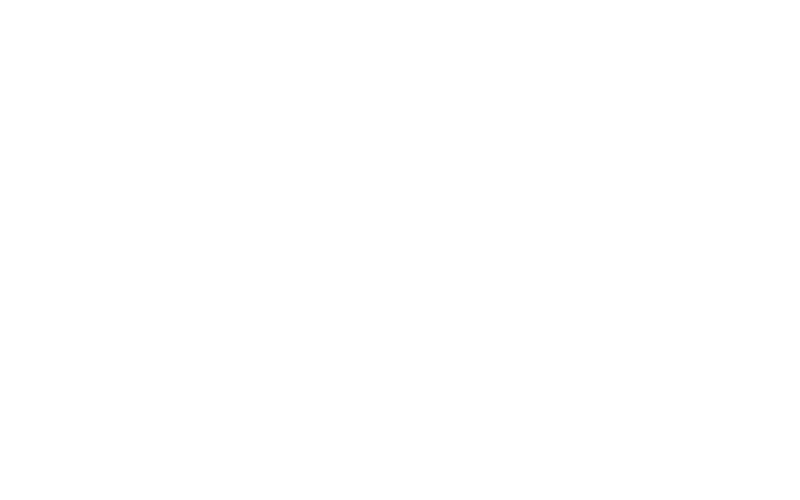

In [14]:
plot_data(country="Germany", state="total", log=True, ticks=20)

### Aktuell Infiziert

<IPython.core.display.Javascript object>


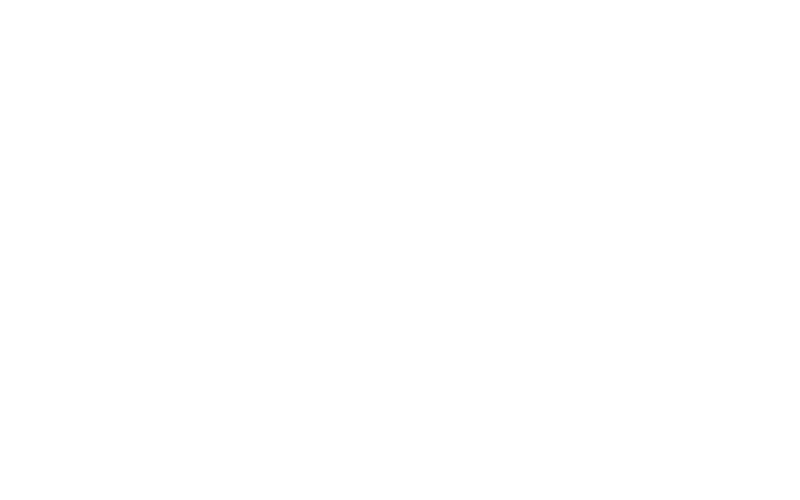

In [15]:
plot_current_infected(country="Germany", state="total", log=False, ticks=24)

### Änderung pro Tag

<IPython.core.display.Javascript object>


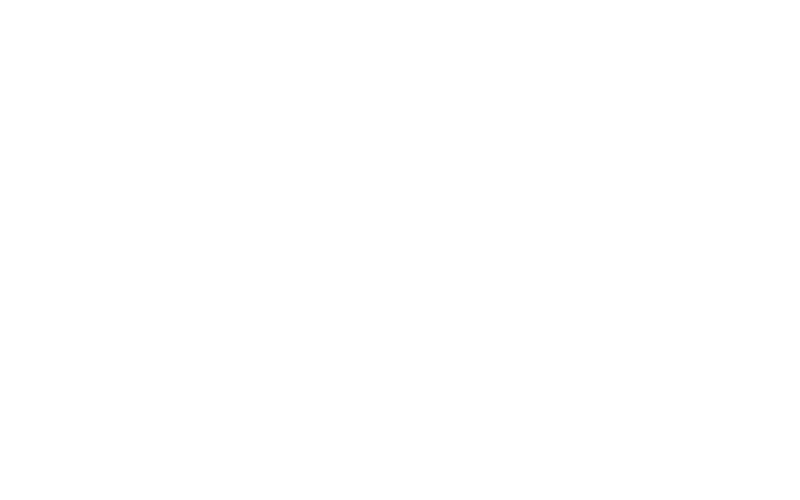

In [16]:
plot_diff(country="Germany", state="total", log=True, ticks=24, sigma=2)

### Obergrenze überschritten

<IPython.core.display.Javascript object>


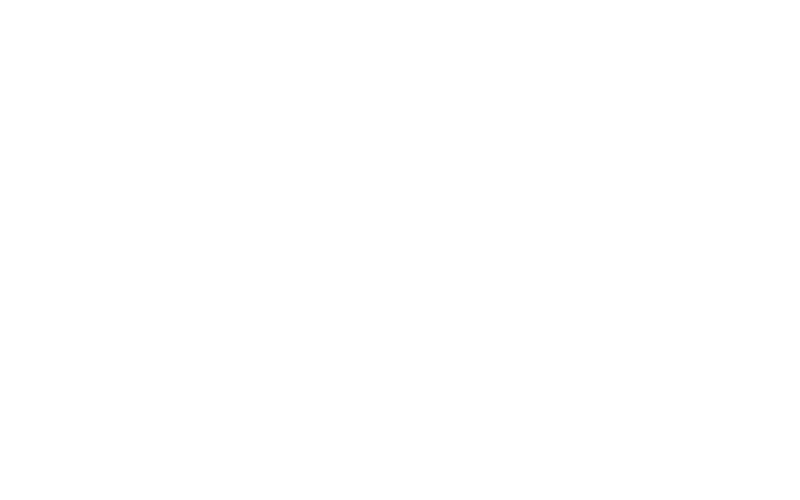

In [17]:
plot_above_treshold(country="Germany", state="total", treshold=1000, log=True, ticks=24)

### Reproduktionszahl R
https://www.spektrum.de/news/was-verraet-die-reproduktionszahl-r-wirklich/1724660

<IPython.core.display.Javascript object>


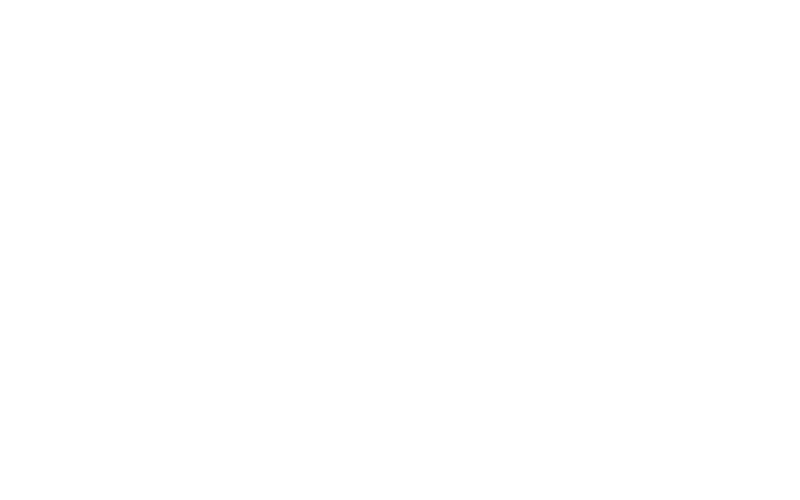

In [19]:
plot_reproduction_number("Germany", "total", sigma=1.5, ticks=20, yrange=[0,2])

<IPython.core.display.Javascript object>


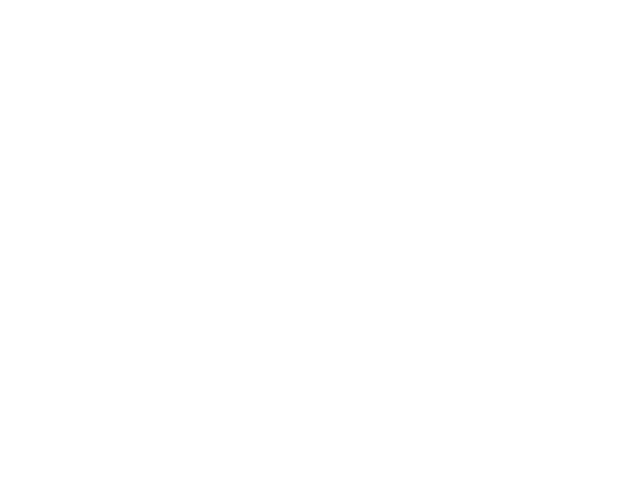

In [69]:
plot_new_vs_current("Germany", "total", ticks=16, logx=False, logy=False)